## Redshift tuning with websky simulations

In [2]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from cosmo_cleaner import fisher

In [3]:
class Combiner():
    def __init__(self, ells, spectra_cross: dict = {}, spectra_auto: dict = {}):
        '''
        ells: bins in l space
        spectra_cross: cross of field fi with g, just use fi as the name 
        spectra_auto: fi, fj crosses
        '''
        self.nbins=len(ells)
        spectra_list=list(spectra_cross.keys())
        self.Nfields = len(spectra_list)
        self.spectra_cross = np.zeros((self.nbins, self.Nfields))
        self.spectra_auto = np.zeros((self.nbins, self.Nfields, self.Nfields))
        
        for i, name in enumerate(spectra_list):
            self.spectra_cross[:, i] = spectra_cross[name]
            for j, name2 in enumerate(spectra_list):
                try:
                    self.spectra_auto[:, i, j] = spectra_auto[name+name2]
                except:
                    self.spectra_auto[:,i,j]= spectra_auto[name2+name]
    
    def combine(self, a):
        cross = np.einsum('...j, ...j -> ...', a, self.spectra_cross)
        auto = np.einsum('...i, ...ij, ...j -> ...', a, self.spectra_auto, a)
        return cross, auto
    
class Forecaster():
    def __init__(self, fsky, ells, names : list = ['k', 'g'], spectra: dict ={}, use_as_data: list = ['kg', 'gg', 'kk']):
        '''
        fsky: fraction of sky
        ells: bins in l space, centers
        spectra:dict in which key corresponds to the name of C_ell, and values are C_ell array
        names: put field to be cleaned first, then the cross correlated one 
        use_as_data: spectra used in practice, e.g. kk, gg or kk, gg, kg 
        '''
        self.names = names
        self.k = names[0]
        self.g = names[1]
        self.Nfields = len(names)
        self.nbins = len(ells)
        self.Nmodes = self.get_Nmodes(ells, fsky) 
        self.fsky = fsky
        self.list_spectra = use_as_data #list(spectra.keys()) 
        self.Nspectra = len(self.list_spectra)
        #self.used = use_as_data
        self.spectra = spectra
        
    def get_Nmodes(self, ells, fsky):
        deltal = ells[1]-ells[0] #ells[1:]-ells[:-1] 
        result = (2*ells*deltal*fsky)
        return result
    
    def get_spectra_element(self, X, Y): 
        try:
            result=self.spectra[X+Y]
        except:
            result=self.spectra[Y+X]
        return result
    
    def get_gaussian_cov(self, X, Y, W, Z):
        result = 1/self.Nmodes*(self.get_spectra_element(X, W)*self.get_spectra_element(Y, Z)+self.get_spectra_element(X, Z)*self.get_spectra_element(Y, W))
        return result
    
    def get_cov(self, X, Y, W, Z):
        return self.get_gaussian_cov(X, Y, W, Z)
    
    def prepare_cov_for_error(self, separator = ','):
        self.cov = np.zeros((self.nbins, self.Nspectra, self.Nspectra))
        self.cov_dict = {}
        for a in self.list_spectra: 
            for b in self.list_spectra:
                X, Y = list(a)
                W, Z = list(b)
                i = self.list_spectra.index(a)
                j = self.list_spectra.index(b) 
                covariance = self.get_cov(X, Y, W, Z) 
                self.cov[:, i, j] = covariance 
                self.cov_dict[a+separator+b]= covariance
        self.invcov = np.linalg.inv(self.cov)
        return 0
    
    def make_fisher_and_err_bars(self, alphas, der_spectra_alpha):
        '''
        a: vector for the combination
        e.g., Ckk = a.T Ckiki a, Ckg = a.T Ckig 
        '''
        Npars = len(alphas)
        assert(der_spectra_alpha.shape[0] == self.nbins) 
        assert(der_spectra_alpha.shape[1] == self.Nspectra) 
        assert(der_spectra_alpha.shape[2] == Npars)
        
        fisher_per_mode = np.einsum('...ik, ...ij, ...jm -> ...km',der_spectra_alpha, np.nan_to_num(self.invcov), der_spectra_alpha)
        self.error_per_mode_non_marginalized = np.nan_to_num(np.diagonal(fisher_per_mode,axis1 = 1, axis2 = 2)**-0.5)
        fisher_integrated = np.sum(fisher_per_mode, axis = 0) 
        print(fisher_integrated)
        self.fisher = fisher_integrated 
        self.error_non_marginalized = np.nan_to_num(np.diag(self.fisher)**-0.5 )
        self.error_marginalized = np.nan_to_num(np.linalg.inv(self.fisher)**0.5 )
        return self.error_marginalized
    

In [4]:
def make_multiple_plots(l, spectra_list = [], labels = [], colors = [], ls = [],title = '', ylabel = '$C_l$', xlabel = '$l$', yscale = 'log', xscale ='linear'):
    plt.title(title)
    for i, c in enumerate(spectra_list):
        plt.semilogy(l, c, color = colors[i], ls = ls[i], label = labels[i]) 
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.yscale(yscale)
    plt.xscale(xscale)
    plt.legend(loc = 'best', fontsize = 15) 
    plt.show()
    plt.close()

# Load the galaxy overdensity map

/global/homes/j/jia_qu/.conda/envs/myenv/lib/python3.7/site-packages/healpy/fitsfunc.py:369: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/global/homes/j/jia_qu/.conda/envs/myenv/lib/python3.7/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 4096
  warnings.warn("NSIDE = {0:d}".format(nside))
/global/homes/j/jia_qu/.conda/envs/myenv/lib/python3.7/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/global/homes/j/jia_qu/.conda/envs/myenv/lib/python3.7/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))
/global/homes/j/jia

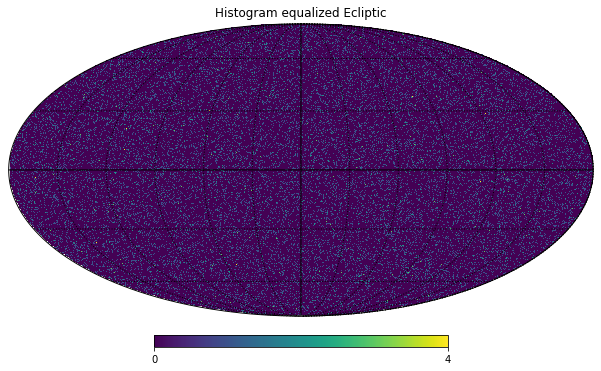

In [5]:

spath="/global/cscratch1/sd/jia_qu/maps/websky/"

galaxy=hp.fitsfunc.read_map(f"{spath}galaxy_overdensity05.fits")
hp.mollview(galaxy, title='Histogram equalized Ecliptic')
hp.graticule()

In [6]:
f='0143'
clcibcib=np.loadtxt(f"/global/homes/j/jia_qu/redshift_cleaning/cibcl{f}.txt")
clgg=np.loadtxt("/global/homes/j/jia_qu/redshift_cleaning/gcls05.txt")
clcibg=np.loadtxt(f"/global/homes/j/jia_qu/redshift_cleaning/gcib{f}05.txt")
clkk=np.loadtxt("/global/homes/j/jia_qu/redshift_cleaning/clkk.txt")
clkg=np.loadtxt("/global/homes/j/jia_qu/redshift_cleaning/clkkg05.txt")
clcibk=np.loadtxt(f"/global/homes/j/jia_qu/redshift_cleaning/clkkcib{f}05.txt")

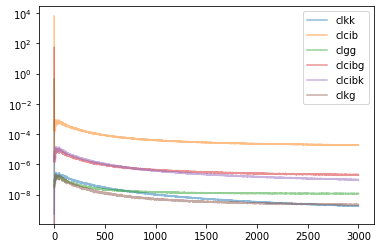

In [7]:
plt.semilogy(clkk,alpha=0.5,label='clkk')
plt.semilogy(clcibcib,alpha=0.5,label='clcib')
plt.semilogy(clgg,alpha=0.5,label='clgg')
plt.semilogy(clcibg,alpha=0.5,label='clcibg')
plt.semilogy(clcibk,alpha=0.5,label='clcibk')
plt.semilogy(clkg,alpha=0.5,label='clkg')

plt.legend()

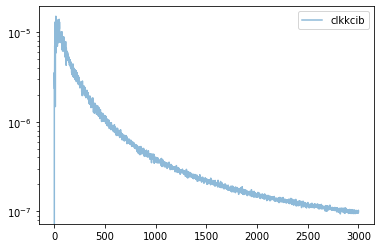

In [8]:
plt.semilogy(clcibk,alpha=0.5,label='clkkcib')
plt.legend()

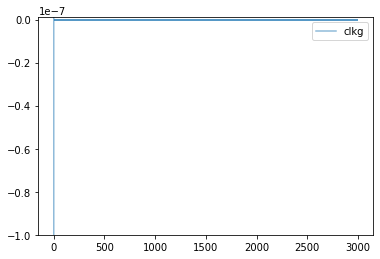

In [9]:
plt.plot(clkg,alpha=0.5,label='clkg')
plt.ylim(-1e-7,1e-9)
plt.hlines(0,0,3000)
plt.legend()

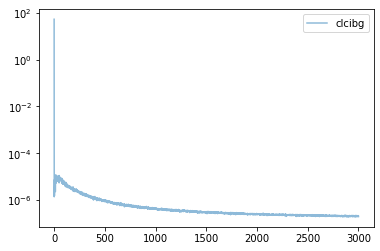

In [10]:
plt.semilogy(clcibg,alpha=0.5,label='clcibg')
plt.legend()

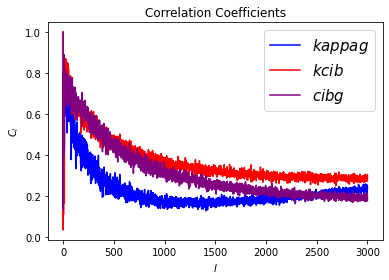

In [13]:
ellrange = np.arange(3001) #np.log(1,2000,100)

rhokg_2 = clkg**2/(clkk*clgg) 
rhokcib_2 = clcibk**2/(clcibcib*clkk) 
rhocibg_2 = clcibg**2/(clcibcib*clgg)
title = 'Correlation Coefficients'
spectra_list = [rhokg_2, rhokcib_2, rhocibg_2] 
labels = ['$kappag$', '$kcib$', '$cibg$'] 
colors = ['blue', 'red', 'purple']
ls = ['-', '-', '-']
make_multiple_plots(ellrange, spectra_list, labels, colors, ls, title, yscale ='linear')

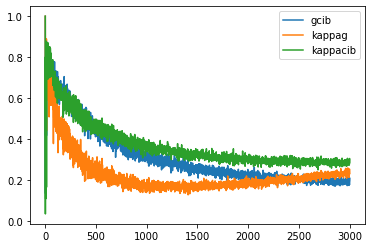

In [14]:
plt.plot(rhocibg_2,label="gcib")
plt.plot(rhokg_2,label="kappag")
plt.plot(rhokcib_2,label="kappacib")
plt.legend()

## calculate Clgg_theory

In [ ]:
#calculate dn/dz for galaxy bias

#once we have this, one can calculate clgg_theory

In [15]:
def loadnz(redshifts, zl,  zh):
    from astropy.io import fits
    zgalaxy = redshifts
    #Galaxy redshift of interest
    galaxyzbins = np.linspace(zl, zh, 20) #to check

    #CREATE dn/dz
    histog = np.histogram(zgalaxy, galaxyzbins)
    nz = histog[0]
    z = histog[1]
    z = (z[1:]+z[:-1])/2.
    return histog[1],z, nz.astype(float)

File too big 20GB, using only the first 300000000 redshifts

In [16]:
redshifts=np.loadtxt("/global/cscratch1/sd/jia_qu/maps/websky/redshift05.txt")

In [17]:
import csv
with open("/global/cscratch1/sd/jia_qu/maps/websky/redshift05.txt") as myfile:
    #reader = csv.reader(myfile, delimiter='\n')
    redshifts = [float(next(myfile).strip()) for x in range(300000000)]
    #redshifts1 = [float(next(myfile).strip()) for x in range(1000000000)]
 


StopIteration: 

In [18]:
nz=loadnz(redshifts, 0,  1)

In [ ]:
len(nz[2])

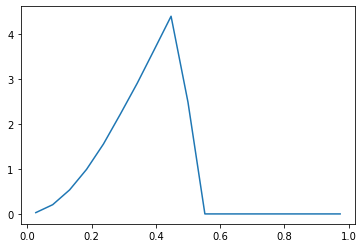

In [19]:
plt.plot(nz[1],nz[2]/np.trapz(nz[2],nz[1]))

In [20]:
from orphics import cosmology,io
import numpy as np
import matplotlib.pyplot as plt

In [21]:
# First initialize a cosmology object with default params
lc = cosmology.LimberCosmology(lmax=3000,pickling=True)

Generating theory Cls...
initializing power...
Initializing CMB window..


In [22]:

lc.addNz(tag="g",zs=nz[1],nz=nz[2]/np.trapz(nz[2],nz[1]),ignore_exists=True)


('Initializing galaxy window for ', 'g', ' ...')


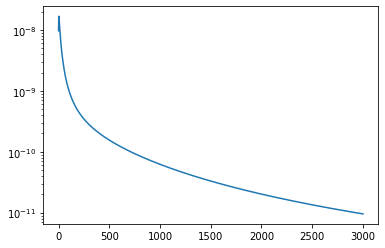

In [26]:
ellrange = np.arange(0,3001,1)
lc.generateCls(ellrange)
clgg0 = lc.getCl("g","g")
clgk0 = lc.getCl("cmb","g")
clkk0 = lc.getCl("cmb","cmb")


plt.figure()
plt.yscale('log')
plt.plot(ellrange,clgg0)


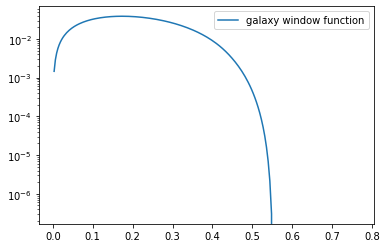

In [27]:
plt.figure()
k=200
plt.semilogy(lc.zs[:k],lc.kernels["g"]['W'][:k],label='galaxy window function')
#plt.plot(lc.zs[:k],lc.kernels["cmb"]['W'][:k])
plt.legend()

In [25]:
plt.plot(ellrange,bp**2*clgg0)
plt.semilogy(ellrange,clgg)


NameError: name 'bp' is not defined

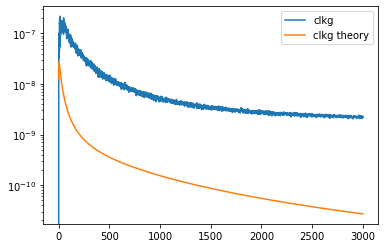

In [28]:
plt.semilogy(ellrange,clkg,label='clkg')
plt.semilogy(ellrange,clgk0,label='clkg theory')
plt.legend()

Fit for b

In [35]:
import numpy as np
from scipy.optimize import minimize, minimize_scalar
start=60
end=1000
# Simple loss-function
def loss(b,f_x, f_y):
    modelY = b*f_x                              # prediction (vector)
    return np.linalg.norm(f_y - modelY, 1)                             # l1-loss (scalar)

result = minimize_scalar(loss, args=(clgk0[start:end], clkg[start:end]))
bias = result.x  
print('minimize_scalar result: ', bias)

minimize_scalar result:  36.208267117151856


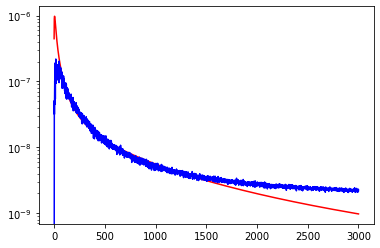

In [37]:
plt.plot( (clgk0*bias)[:], 'r-')
plt.semilogy( clkg[:], 'b-')

In [190]:
pcov

array([[5.70309172]])

In [191]:
plt.plot(b[100:])
plt.hlines(np.mean(b[100:]),0,3000)

NameError: name 'b' is not defined

In [218]:
bp=49.3

In [194]:
bp

25.756747012735538

## Calculate Base Error

In [38]:
spectra = {'kg': clkg, 'gg' :clgg, 'kk': clkk}

In [40]:
fsky=1
num_spectra=2
if num_spectra == 2:
    spectra_used = ['kg', 'gg']
pars = ['b']#, 's'
Npars = len(pars)
der_spectra_alpha = np.ones((len(ellrange), num_spectra, Npars))
#Derivatives with respect to b
der_spectra_alpha[:, 0, 0] = clgk0
der_spectra_alpha[:, 1, 0] = 2*bias*clgg0 

In [41]:
class Combiner():
    def __init__(self, ells, spectra_cross: dict = {}, spectra_auto: dict = {}):
        '''
        ells: bins in l space
        spectra_cross: cross of field fi with g, just use fi as the name 
        spectra_auto: fi, fj crosses
        '''
        self.nbins=len(ells)
        spectra_list=list(spectra_cross.keys())
        self.Nfields = len(spectra_list)
        self.spectra_cross = np.zeros((self.nbins, self.Nfields))
        self.spectra_auto = np.zeros((self.nbins, self.Nfields, self.Nfields))
        
        for i, name in enumerate(spectra_list):
            self.spectra_cross[:, i] = spectra_cross[name]
            for j, name2 in enumerate(spectra_list):
                try:
                    self.spectra_auto[:, i, j] = spectra_auto[name+name2]
                except:
                    self.spectra_auto[:,i,j]= spectra_auto[name2+name]
    
    def combine(self, a):
        cross = np.einsum('...j, ...j -> ...', a, self.spectra_cross)
        auto = np.einsum('...i, ...ij, ...j -> ...', a, self.spectra_auto, a)
        return cross, auto
    
class Forecaster():
    def __init__(self, fsky, ells, names : list = ['k', 'g'], spectra: dict ={}, use_as_data: list = ['kg', 'gg', 'kk']):
        '''
        fsky: fraction of sky
        ells: bins in l space, centers
        spectra:dict in which key corresponds to the name of C_ell, and values are C_ell array
        names: put field to be cleaned first, then the cross correlated one 
        use_as_data: spectra used in practice, e.g. kk, gg or kk, gg, kg 
        '''
        self.names = names
        self.k = names[0]
        self.g = names[1]
        self.Nfields = len(names)
        self.nbins = len(ells)
        self.Nmodes = self.get_Nmodes(ells, fsky) 
        self.fsky = fsky
        self.list_spectra = use_as_data #list(spectra.keys()) 
        self.Nspectra = len(self.list_spectra)
        #self.used = use_as_data
        self.spectra = spectra
        
    def get_Nmodes(self, ells, fsky):
        deltal = ells[1]-ells[0] #ells[1:]-ells[:-1] 
        result = (2*ells*deltal*fsky)
        return result
    
    def get_spectra_element(self, X, Y): 
        try:
            result=self.spectra[X+Y]
        except:
            result=self.spectra[Y+X]
        return result
    
    def get_gaussian_cov(self, X, Y, W, Z):
        result = 1/self.Nmodes*(self.get_spectra_element(X, W)*self.get_spectra_element(Y, Z)+self.get_spectra_element(X, Z)*self.get_spectra_element(Y, W))
        return result
    
    def get_cov(self, X, Y, W, Z):
        return self.get_gaussian_cov(X, Y, W, Z)
    
    def prepare_cov_for_error(self, separator = ','):
        self.cov = np.zeros((self.nbins, self.Nspectra, self.Nspectra))
        self.cov_dict = {}
        for a in self.list_spectra: 
            for b in self.list_spectra:
                X, Y = list(a)
                W, Z = list(b)
                i = self.list_spectra.index(a)
                j = self.list_spectra.index(b) 
                covariance = self.get_cov(X, Y, W, Z) 
                self.cov[:, i, j] = covariance 
                self.cov_dict[a+separator+b]= covariance
        self.invcov = np.linalg.inv(self.cov)
        return 0
    
    def make_fisher_and_err_bars(self, alphas, der_spectra_alpha):
        '''
        a: vector for the combination
        e.g., Ckk = a.T Ckiki a, Ckg = a.T Ckig 
        '''
        Npars = len(alphas)
        assert(der_spectra_alpha.shape[0] == self.nbins) 
        assert(der_spectra_alpha.shape[1] == self.Nspectra) 
        assert(der_spectra_alpha.shape[2] == Npars)
        
        fisher_per_mode = np.einsum('...ik, ...ij, ...jm -> ...km',der_spectra_alpha, np.nan_to_num(self.invcov), der_spectra_alpha)
        self.error_per_mode_non_marginalized = np.nan_to_num(np.diagonal(fisher_per_mode,axis1 = 1, axis2 = 2)**-0.5)
        fisher_integrated = np.sum(fisher_per_mode, axis = 0) 
        print(fisher_integrated)
        self.fisher = fisher_integrated 
        print(self.fisher)
        self.error_non_marginalized = np.nan_to_num(np.diag(self.fisher)**-0.5 )
        self.error_marginalized = np.nan_to_num(np.linalg.inv(self.fisher)**0.5 )
        return self.error_marginalized
    

In [42]:
F_kg_gg_only = Forecaster(fsky, ellrange, ['k', 'g'], spectra, use_as_data =spectra_used)

In [43]:
F_kg_gg_only.prepare_cov_for_error()
err_kg_gg_only = F_kg_gg_only.make_fisher_and_err_bars(pars, der_spectra_alpha) 
print(f'Base error is {err_kg_gg_only}')

[[360221.17189205]]
[[360221.17189205]]
Base error is [[0.00166615]]


/global/homes/j/jia_qu/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/global/homes/j/jia_qu/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: divide by zero encountered in power


In [45]:
## Now combine convergence and CIB
spectra_cross = {'k': clkg, 'i': clcibg}
spectra_auto = {'kk': clkk, 'ii': clcibcib, 'ki': clcibk}
C = Combiner(ellrange, spectra_cross, spectra_auto)
a = np.ones((len(ellrange), 2)) 
cross,auto = C.combine(a = a)
#cross = clkg #do not change clkg, as ideally this should not be affected by cleaning, in this case they are the same
spectra = {'kg': cross, 'gg' :clgg, 'kk': auto}
pars = ['b']#, 's']
Npars = len(pars)
der_spectra_alpha = np.ones((len(ellrange), 3, Npars))
#Derivatives with respect to b
der_spectra_alpha[:, 0, 0] = cross/bias
der_spectra_alpha[:, 1, 0] = 2*bias*clgg0 
der_spectra_alpha[:, 2, 0] = clkk*0
F = Forecaster(fsky, ellrange, ['k', 'g'], spectra)
F.list_spectra
F.prepare_cov_for_error()
F.make_fisher_and_err_bars(pars, der_spectra_alpha)

[[667547.40784925]]
[[667547.40784925]]


/global/homes/j/jia_qu/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/global/homes/j/jia_qu/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: divide by zero encountered in power


array([[0.00122394]])

In [46]:
def get_errors(x):
    a=x.reshape(a0)
    cross,auto=C.combine(a=a)
    cross=clkg #I want this to be preserved
    spectra={'kg':cross,'gg':clgg,'kk':auto}
    F=Forecaster(1.,ellrange,['k','g'],spectra)
    F.prepare_cov_for_error()
    result=F.make_fisher_and_err_bars(pars,der_spectra_alpha)
    return result[0][0]

In [52]:
 #here just put weights on CIB
def get_errors_v2(x):
    a = np.ones((len(ellrange), 2)) 
    a[:, 1] = x
    cross, auto = C.combine(a = a)
    #cross = clkg #note, I want this to be preserved. See plot below, cleaning reduce cross correlation
    spectra = {'kg': cross, 'gg' :clgg, 'kk': auto}
    F = Forecaster(1., ellrange, ['k', 'g'], spectra) 
    F.prepare_cov_for_error()
    result = F.make_fisher_and_err_bars(pars, der_spectra_alpha) 
    return result[0][0]

In [53]:
def get_min_spec(i):
    def min_spec(x):
        a = np.ones((len(ellrange), 2)) 
        a[i, 1] = x
        cross, auto = C.combine(a = a) 
        return auto[i]
    return min_spec

In [54]:
#optimize new kk
from scipy import optimize
all_x = []
for i in range(len(ellrange)):
    result = optimize.minimize(get_min_spec(i), x0 = 1., tol = 1e-20, method ='SLSQP', options = {'ftol': 1e-20, 'xtol': 1e-10, 'disp': False})
    all_x += [result.x[0]] 
all_x = np.array(all_x)

/global/homes/j/jia_qu/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:5: OptimizeWarning: Unknown solver options: xtol
  """


In [55]:
err_min_kk = get_errors_v2(all_x) 
print(err_min_kk)

[[18956837.87952683]]
[[18956837.87952683]]
0.00022967675945933787


/global/homes/j/jia_qu/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/global/homes/j/jia_qu/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: divide by zero encountered in power


In [56]:
print(f'With respect to original {err_kg_gg_only}, we have an improvement of{(abs(err_min_kk-err_kg_gg_only)*100)/err_kg_gg_only} percent.')

With respect to original [[0.00166615]], we have an improvement of[[86.21516191]] percent.


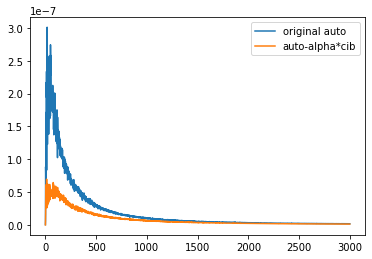

In [208]:
a = np.ones((len(ellrange), 2)) 
a[:, 1] = all_x
newcross, newauto = C.combine(a = a)
plt.plot(clkk,label='original auto')
plt.plot(newauto,label='auto-alpha*cib')
plt.legend()

In [209]:
rhokg_2 = clkg**2/(clkk*clgg) 
new_rhokg=newcross**2/(newauto*clgg) 

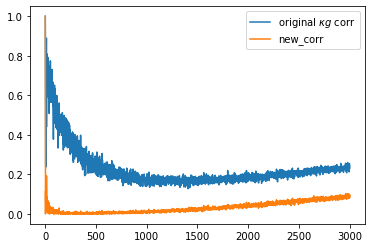

In [210]:
plt.plot(rhokg_2,label='original $\kappa{g}$ corr')
plt.plot(new_rhokg,label='new_corr')
plt.legend()

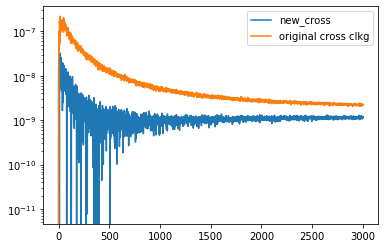

In [211]:
plt.plot(newcross,label='new_cross')
plt.semilogy(clkg,label='original cross clkg')
plt.legend()